In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn import metrics
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from operator import itemgetter
import statsmodels.api as sm
import time
import xgboost as xgb
from random import shuffle
from random import randint


In [25]:
pd.set_option("display.max_rows",50)
df=pd.read_csv('Phishing_Legitimate_full.csv')
dfn=pd.read_csv('Phishing_Legitimate_full.csv')
#koniecznie usuwamy id bo przypisuje do tej kolumny predykcje, anstenie model ma metryki 1
df.drop(['id'],axis=1,inplace=True)

In [26]:
target = 'CLASS_LABEL'
numFeatures = ['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
       'NumDashInHostname', 'NumUnderscore','NumPercent', 'NumQueryComponents', 'NumAmpersand',
       'NumNumericChars','HostnameLength', 'PathLength', 'QueryLength',
       'NumSensitiveWords']
catFeatures = ['AtSymbol','TildeSymbol','NumHash', 'NoHttps','RandomString', 'IpAddress','DomainInSubdomains','DomainInPaths','HttpsInHostname',
              'DoubleSlashInPath','EmbeddedBrandName','PctExtHyperlinks','PctExtResourceUrls', 'ExtFavicon', 'InsecureForms',
       'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction',
       'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch',
       'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow',
       'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle',
       'ImagesOnlyInForm','ExtMetaScriptLinkRT','UrlLengthRT','SubdomainLevelRT',
       'PctExtResourceUrlsRT', 'AbnormalExtFormActionR',
       'PctExtNullSelfRedirectHyperlinksRT']

In [27]:
#podział na df i df znormalizowane 
dummLev = pd.get_dummies(dfn[catFeatures], drop_first=True)
dfn = pd.concat([dfn[numFeatures], dummLev, dfn[[target]]], axis=1)
dummLev = pd.get_dummies(df[catFeatures], drop_first=True)
df = pd.concat([df[numFeatures], dummLev, df[[target]]], axis=1)

In [28]:
dfn[numFeatures] = dfn[numFeatures].apply(lambda x: (x-x.mean())/x.std())

In [29]:
features = df.columns.tolist()
features.remove(target)
print(features)
featuresn = dfn.columns.tolist()
featuresn.remove(target)
print(featuresn)

['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash', 'NumDashInHostname', 'NumUnderscore', 'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumNumericChars', 'HostnameLength', 'PathLength', 'QueryLength', 'NumSensitiveWords', 'AtSymbol', 'TildeSymbol', 'NumHash', 'NoHttps', 'RandomString', 'IpAddress', 'DomainInSubdomains', 'DomainInPaths', 'HttpsInHostname', 'DoubleSlashInPath', 'EmbeddedBrandName', 'PctExtHyperlinks', 'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms', 'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction', 'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch', 'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow', 'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle', 'ImagesOnlyInForm', 'ExtMetaScriptLinkRT', 'UrlLengthRT', 'SubdomainLevelRT', 'PctExtResourceUrlsRT', 'AbnormalExtFormActionR', 'PctExtNullSelfRedirectHyperlinksRT']
['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash', 'NumDashInHostname', 'NumUnderscor

In [30]:
rhs = "+".join(features)
rhs

'NumDots+SubdomainLevel+PathLevel+UrlLength+NumDash+NumDashInHostname+NumUnderscore+NumPercent+NumQueryComponents+NumAmpersand+NumNumericChars+HostnameLength+PathLength+QueryLength+NumSensitiveWords+AtSymbol+TildeSymbol+NumHash+NoHttps+RandomString+IpAddress+DomainInSubdomains+DomainInPaths+HttpsInHostname+DoubleSlashInPath+EmbeddedBrandName+PctExtHyperlinks+PctExtResourceUrls+ExtFavicon+InsecureForms+RelativeFormAction+ExtFormAction+AbnormalFormAction+PctNullSelfRedirectHyperlinks+FrequentDomainNameMismatch+FakeLinkInStatusBar+RightClickDisabled+PopUpWindow+SubmitInfoToEmail+IframeOrFrame+MissingTitle+ImagesOnlyInForm+ExtMetaScriptLinkRT+UrlLengthRT+SubdomainLevelRT+PctExtResourceUrlsRT+AbnormalExtFormActionR+PctExtNullSelfRedirectHyperlinksRT'

In [32]:
def CVTest(nFolds = 5, randomState=2020, debug=False):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Listy do zapisywania wyników
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    for train, test in kf.split(df.index.values):
        # Estymacja modelu GLM
        mod = sm.GLM.from_formula(formula="CLASS_LABEL ~ "+rhs,
                                  data=df.iloc[train], family=sm.families.Binomial())
        res = mod.fit()
        predsTrain = res.predict()
        preds = res.predict(df.iloc[test])
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        trainScore = roc_auc_score((df.CLASS_LABEL.iloc[train]==1),predsTrain)
        testScore = roc_auc_score((df.CLASS_LABEL.iloc[test]==1),preds)
        
        # Zapisanie wyników dopasowania w foldach
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

def CVTestSVM(nFolds = 5, randomState=2020, debug=False, sampleSize = 5000, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)
    # Listy na wyniki:
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    for train, test in kf.split(dfn.index.values):
        # Przygotowanie estymatora
        clf = SVC(probability=True, max_iter=-1, random_state=2020, tol=0.001, cache_size=500, *args, **kwargs)
        # Wyświetlenie wywołania funkcji
        if debug:
            print(clf)
        #Zmniejszenie zbioru treningowego
        sampleSize = sampleSize
        X = dfn.iloc[train].sample(sampleSize)
        # Trenowanie modelu
        clf.fit(X[features], X[target])

        # Przygotowanie prognoz dla zbioru traeningowego i testowego
        # UWAGA Sklearn zwracałbędzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(dfn.iloc[train][features])[:,1]
        preds = clf.predict_proba(dfn.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(dfn.iloc[test].index.tolist().copy())
        
        # Policzenie statystyka lda każdego foldu
        trainScore = roc_auc_score((dfn[target].iloc[train]==1), predsTrain)
        testScore = roc_auc_score((dfn[target].iloc[test]==1), preds)
        
        # Zapisanie wyników do list
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

def run_xgb(train, validate, features, target, # argumenty obowiązkowe
            eta=0.03, max_depth=7, subsample = 0.7, colsample_bytree = 0.7, # hiperparametry
            colsample_bylevel=1,lambdaX = 1, alpha=0, gamma=0, min_child_weight=0, # hiperparametry
            rate_drop = 0.2, skip_drop=0.5, # hiperparametry
            num_boost_round = 1000, early_stopping_rounds = 50, # hiperparametry
            debug=True, eval_metric= ["auc"], objective = "binary:logistic", # konfiguracja
            seed=2017, booster = "gbtree", tree_method="exact", grow_policy="depthwise"): # konfiguracja
   
   
    start_time = time.time()
    paramList= ['eta', 'max_depth',
         'subsample', 'colsample_bytree', 'colsample_bylevel',
         'lambdaX', 'alpha', 'gamma', 'min_child_weight',
         'num_boost_round', 'early_stopping_rounds',
         'rate_drop', 'skip_drop',
         'eval_metric', 'objective', 
          'seed', 'booster', 'tree_method', 'grow_policy']
    
    # Stworzenie słownika do przekazania do XGB
    params = dict()
    for param in paramList:
        params[param]=eval(param)
    if(debug):
        for param in paramList:
            print(param, eval(param), end=", ")
        print('\nLength train:', len(train.index))
        print('Length valid:', len(validate.index))

    # Automatyczne przekazanie liczby klas dla wielu poziomów klasyfikacji
    if (params["objective"]=="multi:softmax" or params["objective"]=="multi:softprob"):
        params["num_class"]=train[target].nunique()
    params["silent"]=1
    
    # XGB wymaga w słowniku parametrów słowa kluczowego lambda, poniżej workaround
    params["lambda"]=lambdaX
    
    # Przekształcenie zbiorów do struktury DMatrix
    # Struktura danych DMatrix pozwala na efektywne tworzenie drzew
    dtrain = xgb.DMatrix(train[features].values, train[target].values, feature_names=train[features].columns.values)
    dvalid = xgb.DMatrix(validate[features].values, validate[target].values, feature_names=validate[features].columns.values)

    # Stworzenie listy zbiorów do ealuacji
    evals = [(dtrain, 'train'), (dvalid, 'valid')]
    
    # Stworzenie zmiennej słownikowej do przekazania
    train_history = dict()

    # Uruchomienie algorytmu trenującego
    gbm = xgb.train(params, dtrain, 
                    num_boost_round, early_stopping_rounds=early_stopping_rounds,
                    evals=evals, evals_result=train_history, verbose_eval=debug)
    
    # Obliczenai statystyk i dodatkowych wartości
    score = gbm.best_score

    # Przekształcenie historii trenowania do Pandas Data Frame
    trainHistory = dict()
    for key in train_history.keys():
        for metric in train_history[key].keys():
            trainHistory[key+metric.upper()]=train_history[key][metric]
    train_history = pd.DataFrame(trainHistory)

    # Zapis przewidywanych wartości dla zbioru walidacyjnego dla najlepszej (z punktu widzenia walidacji) iteracji
    trainPred = gbm.predict(dtrain, ntree_limit=gbm.best_iteration)
    testPred = gbm.predict(dvalid, ntree_limit=gbm.best_iteration)

    # Przygotowanie posortowanej listy dla wazności zmiennych, zamaist słownika
    imp = gbm.get_fscore()
    imp = sorted(imp.items(), key=itemgetter(1), reverse=True)

    impFig=None
    if(debug):
        print('Czas trenowania: {} minut'.format(round((time.time() - start_time)/60, 2)))
        # Skorzystanie z wbudowanej funkcji wizualizującej waznośc zmiennych
        impFig, ax = plt.subplots()
        xgb.plot_importance(gbm, ax=ax)
    return score, trainPred, testPred, train_history, impFig, imp

def plotROCs(results):
    ''' Funkcja, do rysowania szeregu wyników krzywych ROC dla poszczególnych eksperymentów
    results - lista wyników jako 3 elementowe tuple (true, pred, label)
    '''

    # Ustalanie wielkości rysunku
    fig, ax = plt.subplots(figsize=(10,9))

    for true, pred, label in results:
        # Obliczenie punktów potrzebnych do narysowani akrzywej ROC
        # funkcja roc_curve zwarca trzy serie danych, fpr, tpr oraz poziomy progów odcięcia
        fpr, tpr, thresholds = roc_curve(true, pred)
        # Obliczamy pole powierzchni pod krzywą
        rocScore = roc_auc_score(true, pred)
        rocScore = round(rocScore, 3)

        # Grubość krzywej
        lw = 2

        # Rysujemy krzywą ROC
        ax.plot(fpr, tpr, lw=lw, label=f'{label}: {rocScore}')
    # Rysujemy krzywą 45 stopni jako punkt odniesienia
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    # Dodajemy lekkie marginesy do zakresu aby krzywa nie pokrywała się z osiami
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver operating characteristic - {rocScore}')
    ax.legend(loc="lower right")
    plt.show()

def CVTestXGB(nFolds = 5, randomState=2020, features=features, debug=False, *args, **kwargs):
    
    # Przygotujmy walidację krzyżową
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Zapisanie wyników ze zbioru treningowego i testowego
    testResults = []
    trainResults = []
    
    # Przechowajmy również predykcje dla poszczególnych foldów
    predictions = []
    
    # Razem z informacją o tym, jaki był ich indeks w oryginalnym zbiorze danych
    indices = []
    
    # Przygotujmy listę historii
    hists = []
    fold = 1
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(df.iloc[train], df.iloc[test],
                                                                         features, target, debug=debug, *args, **kwargs)

        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(testPred.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        trainScore = roc_auc_score(df[target].iloc[train], trainPred)
        testScore = roc_auc_score(df[target].iloc[test], testPred)
        
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices, pd.concat(hists, axis=1)

def CVTestRFClass(nFolds = 5, randomState=2020, debug=False, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)
    # listy do przechowywania wyników:
    testResults = []
    trainResults = []
    predictions = []
    indices = []

    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = RandomForestClassifier(*args, **kwargs, random_state=randomState, n_jobs=-1)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie dopasowania za pomocą metryki ROC-AUC
        trainScore = roc_auc_score((df[target].iloc[train]==1), predsTrain)
        testScore = roc_auc_score((df[target].iloc[test]==1), preds)
        
        # Zapisanie wyników do listy 
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

def CVTestNBGaussian(nFolds = 5, randomState=2020, debug=False, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Lista z wynikami
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = GaussianNB(*args, **kwargs)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie ROC-AUC dla foldów
        trainScore = roc_auc_score((df[target].iloc[train]==1), predsTrain)
        testScore = roc_auc_score((df[target].iloc[test]==1), preds)
        
        # Zapisanie wyników dla foldów
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

def CVTestKNN(features=featuresn, nFolds = 5, randomState=2020, debug=False, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Listy z wynikami
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(dfn1.index.values):
        # Przygotowanie estymatora
        clf = neighbors.KNeighborsClassifier(*args, **kwargs)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(dfn1.iloc[train][features], dfn1.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(dfn1.iloc[train][features])[:,1]
        preds = clf.predict_proba(dfn1.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(dfn1.iloc[test].index.tolist().copy())
        
        # Policzenie ROC-AUC dla foldów
        trainScore = roc_auc_score((dfn1[target].iloc[train]==1), predsTrain)
        testScore = roc_auc_score((dfn1[target].iloc[test]==1), preds)
        
        # Zapisanie wyników dla foldów
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

In [33]:
dfn1 = dfn.copy()
dfn1["SubmitInfoToEmail"]=dfn1["SubmitInfoToEmail"]*4
dfn1["InsecureForms"]=dfn1["InsecureForms"]*2
dfn1["ImagesOnlyInForm"]=dfn1["ImagesOnlyInForm"]*4
dfn1["ExtMetaScriptLinkRT"]=dfn1["ExtMetaScriptLinkRT"]*0.8
trainResults, testResults, predictions, indices = CVTestKNN(features=features,n_neighbors=14, n_jobs=-1, p=1)
print(np.mean(testResults))

modelkNN = {
    "name":"KNN",
    "description":"Pierwszy dopracowany model KNN, 14 sąsiadów z wszystkimi zmiennymi",
    "specification":'n_neighbors=30, n_jobs=-1, p=1, features=features',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.9906375958030411


In [34]:
trainResults, testResults, predictions, indices = CVTest(nFolds = 5, randomState=2020)
print(np.mean(trainResults), np.mean(testResults))
modelLogit = {
    "name":"Logit",
    "description":"Model Logit ",
    "specification":'nFolds= 5 randomState = 2020',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.9855539816948031 0.9838801178113986


In [35]:
trainResults, testResults, predictions, indices = CVTestNBGaussian(debug=True)
print(np.mean(testResults))
modelNB = {
    "name":"NB",
    "description":"Prosty model Naive Bayes",
    "specification":'',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

GaussianNB()
Train AUC: 0.9461602226105008 Valid AUC: 0.9465980775307911
GaussianNB()
Train AUC: 0.9462892080764995 Valid AUC: 0.9419381700009707
GaussianNB()
Train AUC: 0.9442639053360207 Valid AUC: 0.9526926681061166
GaussianNB()
Train AUC: 0.9474976015135295 Valid AUC: 0.9377637986403387
GaussianNB()
Train AUC: 0.9458037278183247 Valid AUC: 0.9464331608290208
0.9450851750214475


In [42]:
trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=50, max_depth=20,
                                                                    max_features=4,
                                                                    min_samples_split=4, min_samples_leaf=1)
print(np.mean(trainResults), np.mean(testResults))

modelRF = {
    "name":"RF",
    "description":"Model RF, ze zmiennymi kategorycznymi z LE",
    "specification":'n_estimators=50, max_depth=20, max_features=4, min_samples_split=4, min_samples_leaf=1',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.9999929873494553 0.9981700601888482


In [37]:
trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=9, subsample = 0.4, colsample_bytree = 0.9, lambdaX=1, gamma=0.01)
print(np.mean(testResults))

modelXGB = {
    "name":"XGB",
    "description":"Model XGB, ze zmiennymi kategorycznymi z LE",
    "specification":'max_depth=9, subsample = 0.4, colsample_bytree = 0.9, lambdaX=1, gamma=0.01',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

[18:48:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:48:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:48:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:48:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:48:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

0.9990033091305189


C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [38]:
trainResults, testResults, predictions, indices = CVTestSVM(debug=False, kernel="rbf", C=25)
print(np.mean(testResults))
modelSVM = {
        "name":f"SVM RBF = 25",
        "description":"Testy z C i kernelem RBF",
        "specification":'kernel="rbf" C=25,',
        "trainResults":trainResults.copy(),
        "testResults":testResults.copy(),
        "predictions":predictions.copy(),
        "indices":indices.copy(),
}

0.9947590670601189


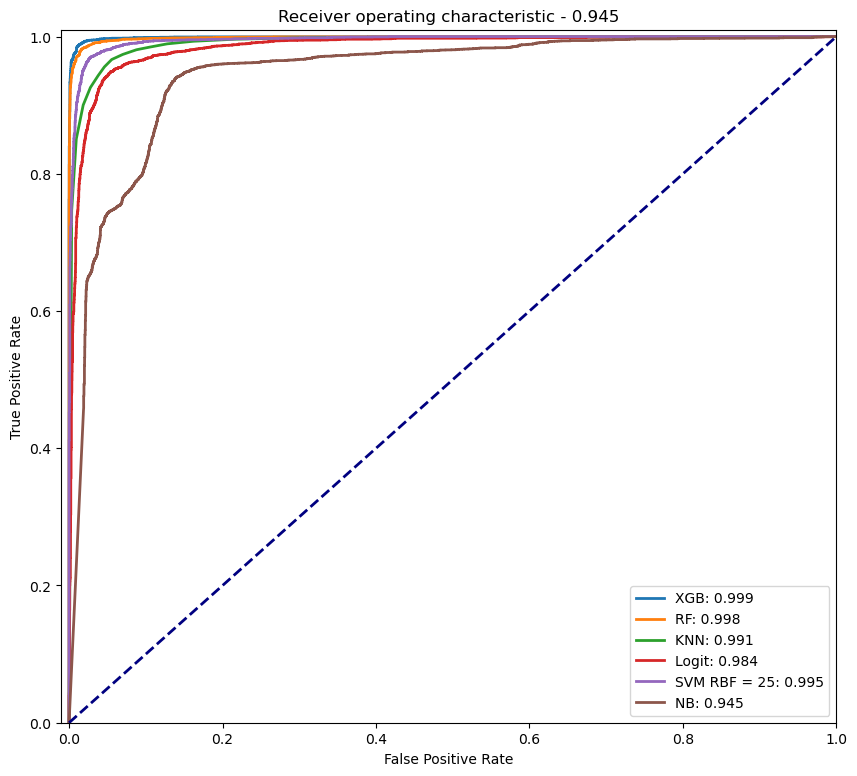

In [39]:
res2plot = []
true = (df[target]==1).sort_index()
for result in [modelXGB, modelRF, modelkNN, modelLogit, modelSVM, modelNB]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Wywołujemy funkcję do rysowania
plotROCs(res2plot)